In [1]:
from torchvision.datasets import VisionDataset, Flickr30k
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
from collections import defaultdict
from PIL import Image
import numpy as np
import nltk
from collections import Counter
import pickle
from tqdm import tqdm
from torchvision import transforms 

In [2]:
flickr_data = Flickr30k('../flickr30k-images', '../flickr30k-captions/results_20130124.token')
flickr_data.__len__

<bound method Flickr30k.__len__ of Dataset Flickr30k
    Number of datapoints: 31783
    Root location: ../flickr30k-images>

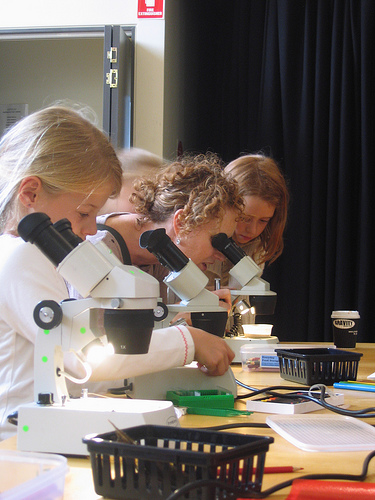

- Three women are working with microscopes while wearing white .
- Three white women in white shirts are using microscopes .
- Three blond women are looking in microscopes .
- Four girls look at objects under a microscope .
- Girls wearing white peer into telescopes .


In [7]:
n = np.random.randint(31_783)
display(flickr_data.__getitem__(n)[0])
for caption in flickr_data.__getitem__(n)[1]:
    print('-',caption)

In [10]:
# r_channel_sum = 0
# g_channel_sum = 0
# b_channel_sum = 0
# count = 0
# filepath = 'flickr30k-images'
# for filename in os.listdir(filepath):
#     if filename[-3:] == 'jpg':
#         img = np.array(Image.open(os.path.join(filepath, filename)).convert('RGB'))
#         r_channel_sum += np.sum(img[:,:,0])
#         g_channel_sum += np.sum(img[:,:,1])
#         b_channel_sum += np.sum(img[:,:,2])
#         count += img.shape[0] * img.shape[1]
# print(r_channel_sum/count)
# print(g_channel_sum/count)
# print(b_channel_sum/count)

__Mean : (113.2971859326401, 107.42922106881713, 98.14465223794616) -> (0.444, 0.421, 0.385)__ 

In [ ]:
# r_channel_sum = 0
# g_channel_sum = 0
# b_channel_sum = 0
# count = 0
# filepath = 'flickr30k-images'
# for filename in os.listdir(filepath):
#     if filename[-3:] == 'jpg':
#         img = np.array(Image.open(os.path.join(filepath, filename)).convert('RGB'))
#         r_channel_sum += np.sum(np.square(img[:,:,0] - 113.2971859326401))
#         g_channel_sum += np.sum(np.square(img[:,:,1] - 107.42922106881713))
#         b_channel_sum += np.sum(np.square(img[:,:,2] - 98.14465223794616))
#         count += img.shape[0] * img.shape[1]
# print(np.sqrt(r_channel_sum/count))
# print(np.sqrt(g_channel_sum/count))
# print(np.sqrt(b_channel_sum/count))       

__Standard Deviation : (72.70319478374329, 70.71527787982022, 72.88658377627682) -> (0.285, 0.277, 0.286)__

In [72]:
def get_splits(filepath = '../flickr30k-images', size = 256, seed = 2020):
    np.random.seed(seed)
    train_set = set()
    val_set = set()
    num_of_dropped = 0
    for filename in tqdm(os.listdir(filepath)):
        if filename[-3:] == 'jpg':
            img = np.array(Image.open(os.path.join(filepath, filename)))
            if img.shape[0] >= size and img.shape[1] >= size:
                selector = np.random.binomial(size=1, n=1, p= 0.1)
                if selector == 0:
                    train_set.add(filename)
                else:
                    val_set.add(filename)
            else:
                num_of_dropped += 1
            
    pickle.dump(train_set,open('train_set.p', 'wb'))
    pickle.dump(val_set,open('val_set.p', 'wb'))
    
    print('Droppped {} Images'.format(num_of_dropped))

In [73]:
get_splits()

100%|██████████| 31785/31785 [01:58<00:00, 269.30it/s]

Droppped 322 Images


In [3]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.all_words = []

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
            self.all_words.append(word)
            
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

    def get_id(self, w):
        return self.word2idx[w]

    def encode_seq(self, l):
        return [self.word2idx[i] if i in self.word2idx else self.word2idx['<unk>'] for i in l]

    def get_token(self, idx):
        return self.idx2word[idx]

    def decode_seq(self, l):
        return [self.idx2word[i] for i in l] 

In [5]:
def build_vocab(ann_file = '../flickr30k-captions/results_20130124.token', threshold = 3):
    """Build a simple vocabulary wrapper."""
    punc_set = set([',',';',':','.','?','!','(',')','``','"'])
    counter = Counter()
    caption_list = []
    split = pickle.load(open('train_set.p', 'rb'))
    ann_file = os.path.expanduser(ann_file)
    with open(ann_file) as fh:
        for line in fh:
            img, caption = line.strip().split('\t')
            if img[:-2] in split:
                caption_list.append(caption)
    for caption in tqdm(caption_list):
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        tokens = [elem for elem in tokens if elem not in punc_set] 
        counter.update(tokens)

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold] #Changed from 4

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')
    vocab.add_word('<break>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [6]:
vocab = build_vocab()
pickle.dump(vocab,open('vocab.p', 'wb'))

100%|██████████| 141960/141960 [00:12<00:00, 11791.31it/s]


In [14]:
# Adapted from https://pytorch.org/docs/stable/_modules/torchvision/datasets/flickr.html#Flickr30k
class Custom_Flickr30k(VisionDataset):
    """`Flickr30k Entities <http://web.engr.illinois.edu/~bplumme2/Flickr30kEntities/>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        ann_file (string): Path to annotation file.
        vocabulary (object): Vocabulary wrapper
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        is_train (boolean): Train set or val set
    """

    def __init__(self, root, ann_file, vocabulary, train=True, transform=None, target_transform=None):
        super(Custom_Flickr30k, self).__init__(root, transform=transform, target_transform=target_transform)
        self.ann_file = os.path.expanduser(ann_file)
        self.train = train
        self.annotations = defaultdict(list)
        self.punc_set = set([',',';',':','.','?','!','(',')'])
        
        if self.train:
            split = pickle.load(open('train_set.p', 'rb'))
            idx=0
            with open(self.ann_file) as fh:
                for line in fh:
                    img_id, caption = line.strip().split('\t')
                    img = img_id[:-2]
                    if img in split:
                        self.annotations[idx].extend([img,caption])
                        idx += 1
            self.ids = np.arange(idx-1)
            
        else:
            split = pickle.load(open('val_set.p', 'rb'))
            idx = -1
            last_image = ''
            with open(self.ann_file) as fh:
                for line in fh:
                    img_id, caption = line.strip().split('\t')
                    img = img_id[:-2]
                    if img in split:
                        if img != last_image:
                            idx += 1
                            last_image = img
                            self.annotations[idx].append(img)
                            self.annotations[idx].append([caption])
                        else:
                            self.annotations[idx][1].append(caption)
            self.ids = np.arange(idx)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is a list of captions for the image.
        """
        instance = self.annotations[index]
        
        img_id = instance[0]
        caption = instance[1]
        
        # Image
        filename = os.path.join(self.root, img_id)
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        if self.train:

            # Captions
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(vocab('<start>'))
            caption.extend([vocab(token) for token in tokens if token not in self.punc_set])
            caption.append(vocab('<end>'))
            target = torch.Tensor(caption)
            
        else:
            # Captions
            target = []
            for item in caption:
                tokens = nltk.tokenize.word_tokenize(str(item).lower())
                target.extend([vocab(token) for token in tokens if token not in self.punc_set])
                target.append(vocab('<break>'))
            
            target = torch.Tensor(target[:-1])

        return img, target


    def __len__(self):
        return len(self.ids)

In [15]:
def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).

    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.

    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.

    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [17]:
# DataLoader parameter
batch_size = 128
num_workers = 2
crop_size = 256
transform = transforms.Compose([
#             transforms.CenterCrop(crop_size),
            transforms.RandomCrop(crop_size),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.444, 0.421, 0.385), 
                                 (0.285, 0.277, 0.286))])

In [18]:
flickr_data = Custom_Flickr30k('../flickr30k-images', '../flickr30k-captions/results_20130124.token', vocab, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=flickr_data, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers,
                                          collate_fn=collate_fn)

In [69]:
from model import SimpleEncoderCNN, SimpleDecoderRNN

# Model parameters
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 1e-3
num_epoch = 5
fine_tune = False

# Initialize models
encoder = SimpleEncoderCNN(embed_size).to(device)
decoder = SimpleDecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Initialize optimization
criterion = torch.nn.CrossEntropyLoss()
if fine_tune:
    params = list(encoder.parameters()) + list(decoder.parameters())
else:
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [70]:
for epoch in range(num_epoch):
    for i, (images, captions, lengths) in tqdm(enumerate(data_loader)):

        # Batch to device
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Optimization
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
          .format(epoch, num_epoch, loss.item(), np.exp(loss.item()))) 

71532it [12:05, 98.60it/s] 

Epoch [0/5], Loss: 2.3998, Perplexity: 11.0206



71532it [12:02, 99.04it/s] 

Epoch [1/5], Loss: 3.7736, Perplexity: 43.5362



71532it [12:01, 99.20it/s] 

Epoch [2/5], Loss: 4.3702, Perplexity: 79.0605



71532it [12:08, 98.15it/s] 

Epoch [3/5], Loss: 2.0808, Perplexity: 8.0108



71532it [11:59, 99.43it/s] 

Epoch [4/5], Loss: 3.2355, Perplexity: 25.4185


In [71]:
encoder.to('cpu')
torch.save(encoder.state_dict(), 'SimpleEncoderCNN.pt')
decoder.to('cpu')
torch.save(decoder.state_dict(), 'SimpleDecoderRNN.pt')

In [23]:
batch_size = 2
flickr_data = Custom_Flickr30k('../flickr30k-images', '../flickr30k-captions/results_20130124.token', vocab, train=False, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=flickr_data, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers,
                                          collate_fn=collate_fn)